<a href="https://colab.research.google.com/github/Neeshi14/pneumoniadisease/blob/main/pneumoniadiseaseclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pneumonia Disease Detection Model**

 These is the pneumonia disease classification model. In these model ,We are using the pretrained model of CNN and bulid the model using the pytorch framework .


In CNN there are many pretraied model but in these we are used the ResNet model.



Import the data using Kaggle Dataset

In [1]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset (replace with actual dataset name)
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Extract ZIP file
import zipfile

zip_path = "/content/chest-xray-pneumonia.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


mv: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


Import the library

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from PIL import Image
from glob import glob

In [3]:
#Setup and Data Loading
train_dir = '/content/dataset/chest_xray/train'
test_dir = '/content/dataset/chest_xray/test'
val_dir = '/content/dataset/chest_xray/val'

In [4]:
print('Number of images in training set = ',str(len(glob(train_dir+'/*/*.jpeg'))))
print('Number of images in validation set = ',str(len(glob(val_dir+'/*/*.jpeg'))))
print('Number of images in testing set = ',str(len(glob(test_dir+'/*/*.jpeg'))))

Number of images in training set =  5216
Number of images in validation set =  16
Number of images in testing set =  624


In [5]:
# Image Parameters
img_width, img_height = 150, 150
batch_size = 32

In [6]:
datasets, pneumonia, normal = ["train", "test", "val"], [], []
directory = '/content/dataset/chest_xray'

for i in datasets:
    path = os.path.join(directory, i)
    normal.extend(glob(os.path.join(path, "NORMAL/*.jpeg")))
    pneumonia.extend(glob(os.path.join(path, "PNEUMONIA/*.jpeg")))
    #normal = glob(os.path.join(path, "NORMAL/*.jpeg"))
    #pneumonia = glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    #normal.extend(normal), pneumonia.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia)))
print("The number of non-pneumonia images is {}".format(len(normal)))

The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


In [7]:
# Data Transformations
train_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]), # ImageNet stats
])

test_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [8]:
# Custom Dataset Class
class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label in self.classes:
            label_dir = os.path.join(root_dir, label)
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                self.image_paths.append(image_path)
                self.labels.append(0 if label == 'NORMAL' else 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')  # Open as grayscale ('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [9]:
# Create DataLoaders
train_dataset = PneumoniaDataset(train_dir, transform=train_transforms)
test_dataset = PneumoniaDataset(test_dir, transform=test_transforms)
val_dataset = PneumoniaDataset(val_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# 2. Load Pretrained ResNet50 (Modified for Grayscale)

model = torchvision.models.resnet50(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2) #Change first layer to accept single channel.

# Freeze pretrained layers
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Load VGG16 pre-trained model
#vgg16 = torchvision.models.vgg16(pretrained=True)

# Modify the classifier (final layers) for binary classification
#num_features = vgg16.classifier[6].in_features
#vgg16.classifier[6] = nn.Linear(num_features, 1)  # Output layer for binary classification


In [12]:
# 3. Add Custom Classification Layers

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

# Make the parameters of the new fully connected layers trainable
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU (if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

In [13]:
from torchinfo import summary
summary(model, input_size=(batch_size, 1, img_width, img_height))
#model.summary()

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 72, 72]          (3,200)
├─BatchNorm2d: 1-2                       [32, 64, 72, 72]          (128)
├─ReLU: 1-3                              [32, 64, 72, 72]          --
├─MaxPool2d: 1-4                         [32, 64, 36, 36]          --
├─Sequential: 1-5                        [32, 256, 36, 36]         --
│    └─Bottleneck: 2-1                   [32, 256, 36, 36]         --
│    │    └─Conv2d: 3-1                  [32, 64, 36, 36]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 36, 36]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 36, 36]          --
│    │    └─Conv2d: 3-4                  [32, 64, 36, 36]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 36, 36]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 36, 36]   

In [14]:
criterion = nn.BCELoss() #BCS-> binaray cross entropy loss
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) # for VGG16 vgg16.parameters()

In [15]:
# 4. Compile and Train

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 0.2956531737342568
Epoch 2/5, Loss: 0.23234900192249042
Epoch 3/5, Loss: 0.21696866221405978
Epoch 4/5, Loss: 0.19769897423913144
Epoch 5/5, Loss: 0.17707519320074033


In [16]:
# 5. Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)
        outputs = model(inputs)
        _,predicted = torch.max(outputs.data, 1)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 79.96794871794872%


In [17]:
def classify_image(image_path, model, transform):

    image = Image.open(image_path).convert('L')  # Open as grayscale
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Get the actual class from the image path
    actual_class = 'PNEUMONIA' if 'PNEUMONIA' in image_path else 'NORMAL'

    with torch.no_grad():
        output = model(image)
        predicted_class = 'PNEUMONIA' if output.item() > 0.5 else 'NORMAL'

    #display the image
    plt.imshow(image.cpu().squeeze(), cmap='gray')  # Remove batch dimension and display
    plt.title(f'Actual: {actual_class}, Predicted: {predicted_class}')
    plt.axis('off')  # Hide axes
    plt.show()

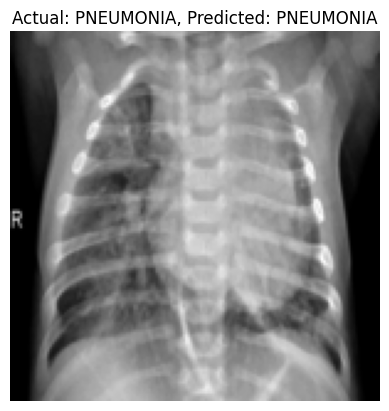

Predicted class for image: None


In [21]:
# Alternatively, classify individual images
image_path = '/content/dataset/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'  # Example image path
predicted_class = classify_image(image_path, model, test_transforms)

print(f'Predicted class for image: {predicted_class}')

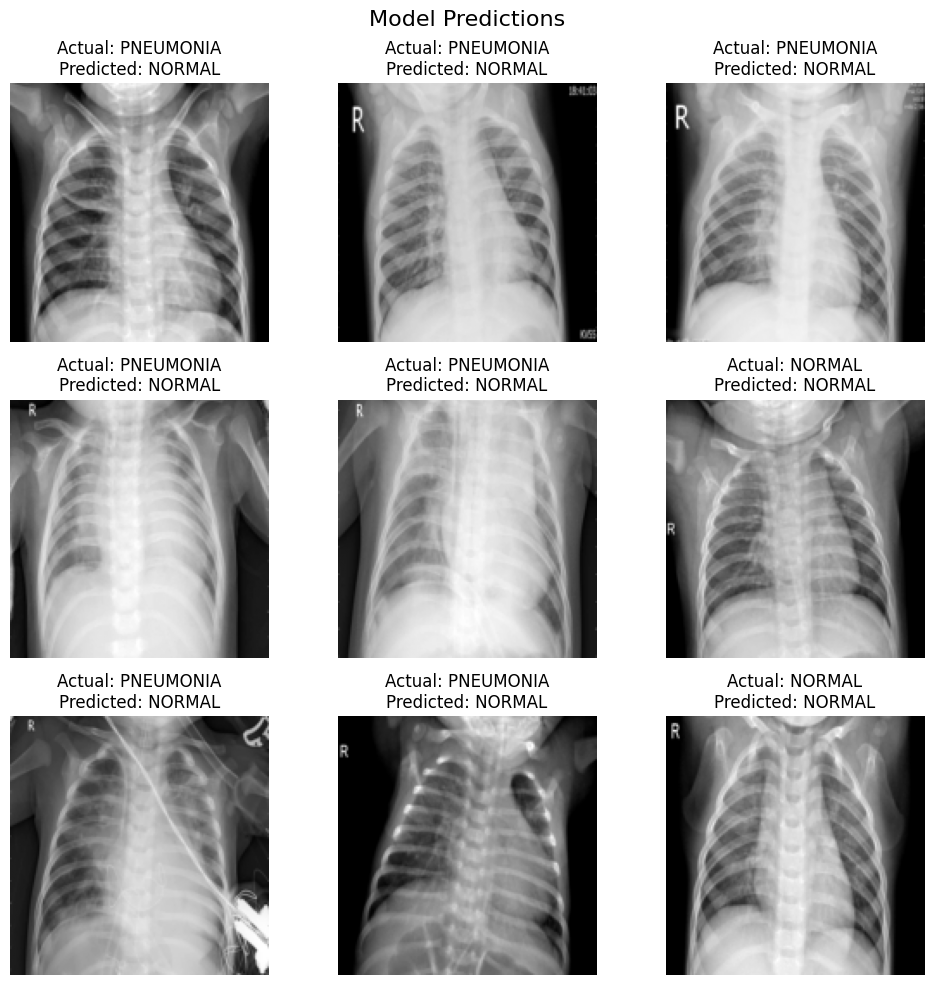

In [20]:
import matplotlib.pyplot as plt
import numpy as np


# Function to display images with predictions
def display_predictions(images, labels, predictions, n_images=9):

    n_images = min(n_images, images.shape[0])  # Limit to available images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid
    fig.suptitle('Model Predictions', fontsize=16)

    for i in range(n_images):
        ax = axes[i // 3, i % 3]  # Get the subplot
        image = images[i].cpu().numpy()  # Move to CPU and convert to NumPy array
        image = image.squeeze()  # Remove the channel dimension if grayscale

        # Display the image
        ax.imshow(image, cmap='gray')
        ax.axis('off')  # Hide axes

        # Set title with actual and predicted labels
        actual_label = 'NORMAL' if labels[i].item() == 0 else 'PNEUMONIA'
        predicted_label = 'NORMAL' if predictions[i].item() == 0 else 'PNEUMONIA'
        title = f'Actual: {actual_label}\nPredicted: {predicted_label}'
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# Get a batch of images and labels from the test_loader
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

# Display predictions for the batch
display_predictions(images, labels, predictions)